# Representation Learning


Information can be represented in many different ways: an image is quickly
processed by our brain using its common visual format however, we would struggle
to make sense of the numerical values of the color channels if written out as a
list of numbers.

![image representation](https://drive.google.com/uc?export=view&id=1qRtI-aX7KcK9YO-BVEbiwjc7Vl-0BFNO)

In many cases, solving a machine learning task efficiently depends on finding
the right representation of the data. For example, the hidden layers of a neural
network classifier give internal representations of the input which were
optimized during training to make separating the classes easier. Similarly,
Principal Component Analysis (PCA) provides a low-dimensional representation of
data sets that reduces multicollinearity and aids downstream modeling.

The goal of _representation learning_ is to find representations of data that
are universally applicable to different downstream tasks. The components of such
a general representation should untangle the variations in the data in a
meaningful way: instead of color channels, an image of a person can be
represented by the shape of their face, whether they wear a glass, their hair
color, etc. These features are likely to be helpful in many naturally occurring
tasks.

Learning representations is an unsupervised approach that can take advantage of
abundant sources of unlabeled data. In contrast, labeled data for real-life
applications is available in only limited amounts which means models risk
overfitting. To overcome this, _semi-supervised learning_ utilizes both labeled
and unlabeled data to build models that generalize better. In particular, one
can first learn general data representations from the unlabeled data and then
use these representations on the labeled data for training a supervised learning
model (e.g., a classifier, a regression model or a recommendation system).

In this lesson, we will explore two approaches to representation learning:

- _autoencoders_, a general training framework for neural networks that learns
  representations by first compressing and then reconstructing the input, and
- _word embeddings_, a text representation approach that maps semantically
  similar words to nearby vectors.


## Autoencoders


The term _autoencoder_ refers to a general neural network architecture and
training procedure that was originally designed for dimension reduction and
learning a useful representation of the input data. The latter can be considered
as a type of automated feature engineering for further modeling tasks.

A typical autoencoder is composed of an $\text{Encoder}()$ and
$\text{Decoder}()$ module, both neural networks. For a given input $x$, the
encoder will first produce an internal representation

$$
h=\text{Encoder}(x)
$$

of the input which then gets fed into the decoder to give the output $r$:

$$
\begin{align}
r & = \text{Decoder}(h) \\
& = \text{Decoder}(\text{Encoder}(x))
\end{align}
$$

The output of the decoder has the same size as the input and we treat this
output $r$ as a _reconstruction_ of the input. More precisely, the autoencoder
is trained to copy the input to the output: we apply a loss that measures the
difference between the original input $x$ and the reconstructed output

$$\text{Loss}(x, \text{Decoder}(\text{Encoder}(x)))$$

and optimize the model weights to minimize this reconstruction error (using
gradient descent, as usual for neural networks).

![autoencoder model](https://drive.google.com/uc?export=view&id=1rGWwf8GuC-pMatNQhG-10lVJ_ZrTFm5H)

The smaller this loss is the better the model is at reconstructing the input.
However, if the model is large or complex enough then it can simply copy-paste
any input which is clearly of no use. So, in order to force the autoencoder to
learn meaningful information about the data, we restrict the capacity of the
model to not allow for perfectly cloning the input: this can be done by limiting
the size of the layers to be smaller than the input dimension or by constraining
the weight matrices in other ways (such as regularization).

As an analogy for the bottle-neck in the architecture, imagine sitting in for a
two-hour lecture with a tiny notebook: you are forced to take notes efficiently,
so you learn to distill information and to disregard irrelevant remarks. The
compress-and-reconstruct process does the same: the model learns an internal
representation that captures those variations in the data that are relevant for
the reconstruction but discards irrelevant noise and random fluctuations.

We will next demonstrate an application of autoencoders in an anomaly detection
scenario by showing that we can achieve very high accuracy (and recall) with
limited amounts of labeled data.


### Anomaly detection using autoencoders


Let's load the data set we will be working with (download from
[here](https://drive.google.com/uc?export=view&id=1rKBHdiCzmv5tZMDYyO_qNGpzeLzktWqr)):


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load the anomaly data set
anomaly_df = pd.read_csv("../_data/anomaly.csv")


Each record is a numeric signal recorded over 100 time steps. The table
furthermore contains an anomaly indicator in the final column but labels are
only available for small subset of the records:


In [2]:
anomaly_df.head()


,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,is_anomaly
0,0.774876,0.749527,0.849705,0.895584,0.871237,0.996273,0.970122,0.967184,0.956711,1.005537,...,-0.614856,-0.619728,-0.709098,-0.810683,-0.844193,-0.922521,-0.941373,-0.952584,-0.947559,NaN
1,-0.409236,-0.517066,-0.892163,-1.143980,-0.849980,-0.435039,0.296482,0.656325,1.146595,1.114730,...,-0.916966,-0.421183,0.126693,0.728599,0.714619,0.948614,0.644869,0.653693,0.226652,NaN
2,0.143215,0.003718,-0.033750,-0.210768,-0.357231,-0.534382,-0.507695,-0.837195,-0.755969,-1.072523,...,0.906579,0.362901,0.279377,0.206621,0.099310,-0.014410,-0.063761,-0.698738,-0.736796,NaN
3,1.015360,0.990314,1.039064,1.051669,1.000144,0.940010,0.942076,0.854310,0.632028,0.535440,...,-0.632403,-0.793801,-0.734205,-0.922971,-1.085247,-1.014509,-0.822559,-0.922360,-0.962470,NaN
4,0.343554,0.321734,0.415900,0.537773,0.773310,0.613971,0.802284,0.846245,1.003881,0.957579,...,-0.854080,-0.924756,-1.016154,-0.989205,-1.065566,-1.012160,-1.023156,-1.039512,-0.923936,NaN


We have 10K rows in the dataset but only 10% of the records are labeled and only
~10% of these labels are marked as an anomaly:


In [3]:
anomaly_df.shape


(10000, 101)

In [5]:
anomaly_df["is_anomaly"].value_counts(normalize=True) * 100


0.0    90.8
1.0     9.2
Name: is_anomaly, dtype: float64

To better understand the data, we can look at some of the normal and anomalous
observations:


In [6]:
normal_signal = anomaly_df[anomaly_df["is_anomaly"] == 0]
anomaly_signal = anomaly_df[anomaly_df["is_anomaly"] == 1]


After seperating the normal and anomalous observations we drop the label column
so we can visualize below.


In [7]:
normal_signal = normal_signal.drop(columns="is_anomaly")
anomaly_signal = anomaly_signal.drop(columns="is_anomaly")


The plot below will show the first 6 rows from the normal samples:


/var/folders/b6/6fn4wmgj471c2xr9pcp8sbdr0000gn/T/ipykernel_76108/2283285000.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, i + 1)


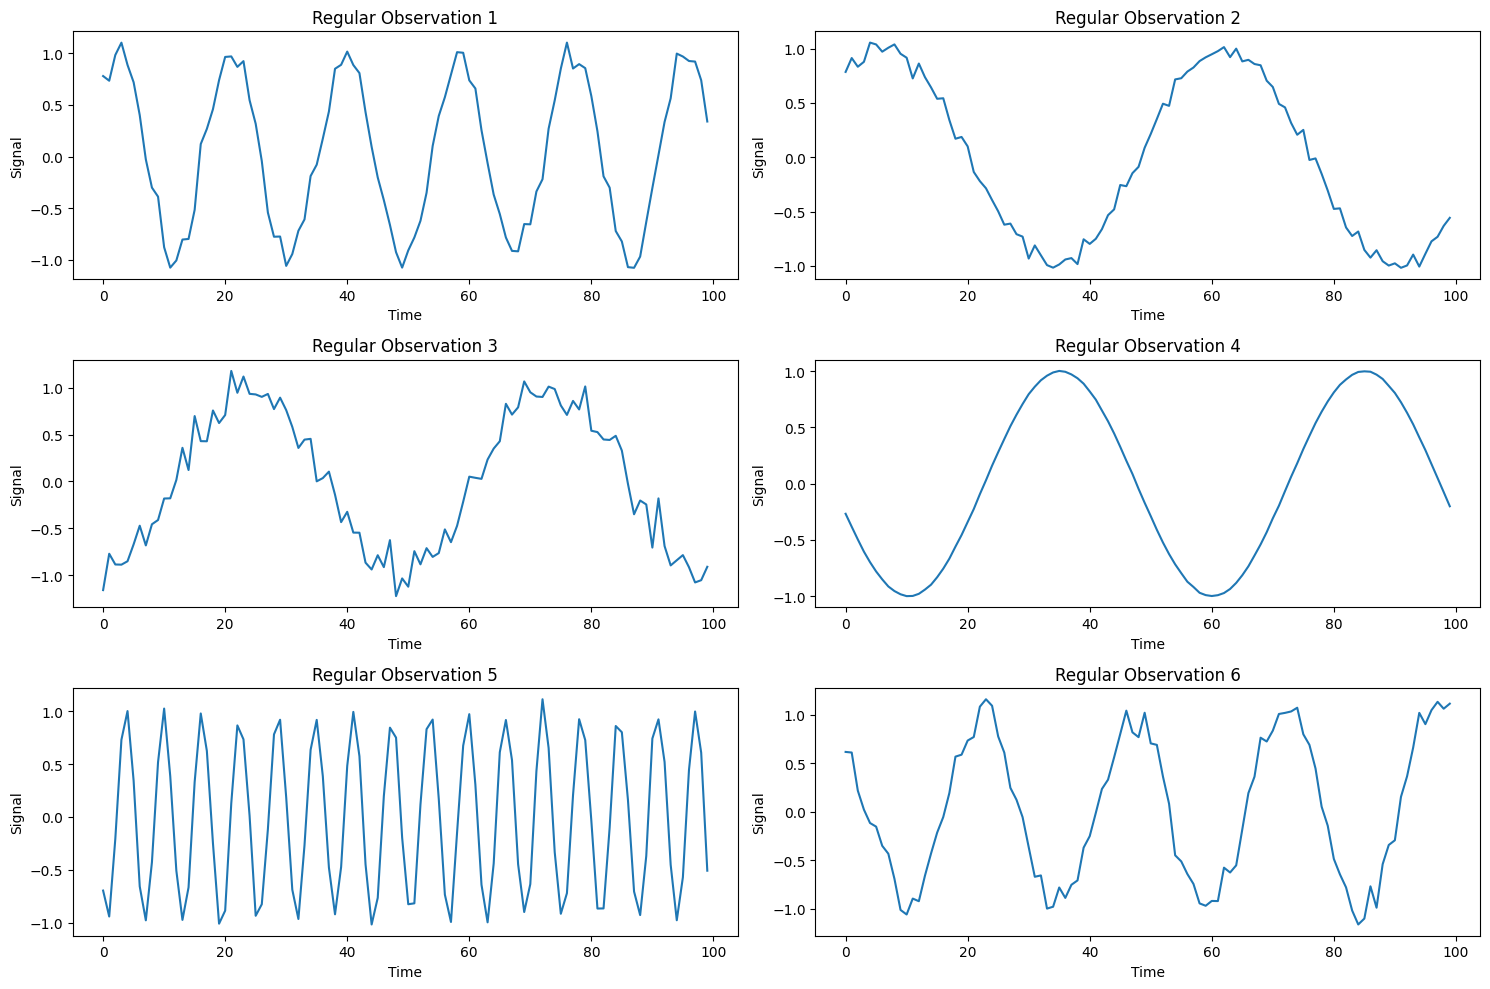

In [16]:
fig = plt.subplots(figsize=(15, 10))

for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.plot(normal_signal.sample(1).values[0])
    plt.ylabel("Signal")
    plt.xlabel("Time")
    plt.title(f"Regular Observation {i+1}")

plt.tight_layout()


We see that each signal resembles a noisy wave function of varying frequency.
Next, let's see how the anomaly signals differ from these:


/var/folders/b6/6fn4wmgj471c2xr9pcp8sbdr0000gn/T/ipykernel_76108/2744976386.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, i + 1)


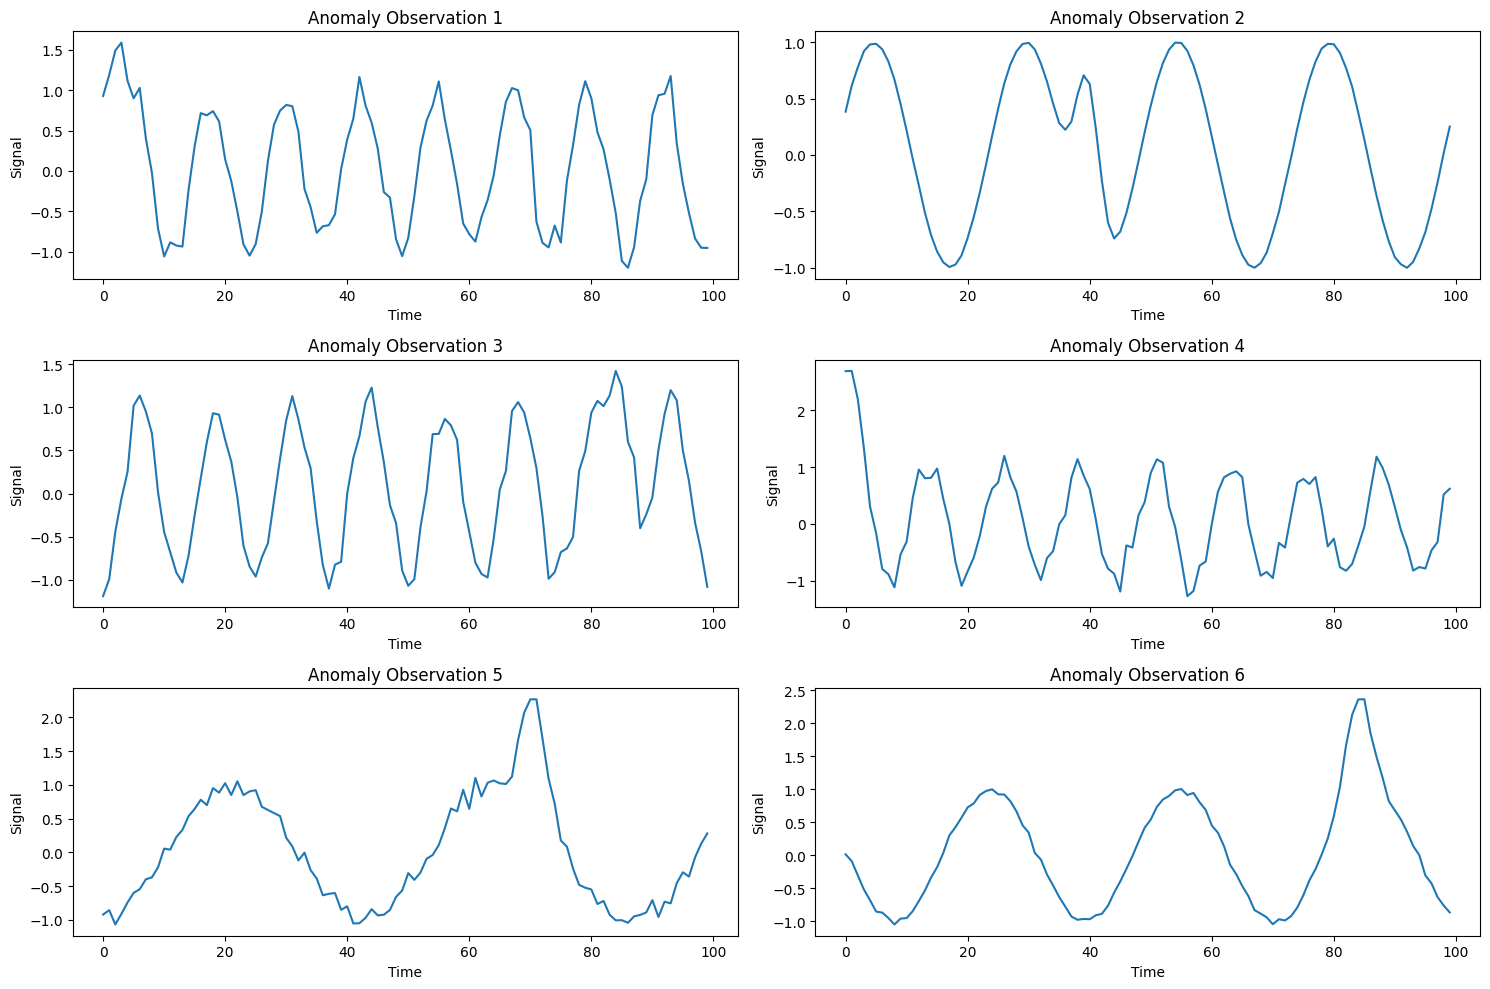

In [17]:
fig = plt.subplots(figsize=(15, 10))

for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.plot(anomaly_signal.sample(1).values[0])
    plt.ylabel("Signal")
    plt.xlabel("Time")
    plt.title(f"Anomaly Observation {i+1}")

plt.tight_layout()


Here, the main difference we can spot is that each wave is further distorted at
a fairly localized spot. Our goal will be to find a model that can accurately
distinguish between normal and anomaly signals.


In general, the main issue with anomaly detection is high class imbalance and
overall the lack of adequate amounts of training data - in real data collection
scenarios, the anomaly labels are often created by human annotators which is
both expensive and time consuming. However, in many cases we do have access to
plenty of unlabeled observations and our goal is to utilize the unlabeled
records to create better classifiers that can detect anomalous records. This
will make our approach fall under the umbrella of _semi-supervised learning_
where we take advantage of both labeled and unlabeled data.


First, we can split our labeled records into training and validation sets.


In [18]:
from sklearn.model_selection import train_test_split

labeled_df = anomaly_df.dropna()

X = labeled_df.drop(columns="is_anomaly")
y = labeled_df["is_anomaly"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, stratify=y, random_state=123)


In [19]:
print(f"Training set size: {X_train.shape[0]}, number of anomaly samples: {int(y_train.sum())}")
print(f"Validation set size: {X_val.shape[0]}, number of anomaly samples: {int(y_val.sum())}")


Training set size: 500, number of anomaly samples: 46
Validation set size: 500, number of anomaly samples: 46


We will create a baseline model by fitting a logistic regression classifier:


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(logreg, {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)

logreg = grid_search.best_estimator_


Best parameters:  {'C': 10}


Let's look at the validation performance:


In [21]:
from sklearn.metrics import classification_report

y_pred_val = logreg.predict(X_val)

print(classification_report(y_val, y_pred_val))


              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       454
         1.0       0.88      0.61      0.72        46

    accuracy                           0.96       500
   macro avg       0.92      0.80      0.85       500
weighted avg       0.95      0.96      0.95       500



Keeping in mind the high class imbalance, the overall accuracy of 96% is not
that impressive - indeed, random guessing would achieve 90% accuracy. Even more
so, the recall score of ~60% is fairly low on class 1, meaning that the model
overlooked 40% of the anomaly signals. So how can we build a better model
(increasing recall while keeping precision high as well) by making use of the
large amounts of unlabeled data?

We will train an autoencoder on the full data set, without using the anomaly
labels, to compress and reconstruct the signal. The encoder will take the
100-time step signal as input, compress it to 5 dimensions (the internal
representation size), and then the decoder module reconstructs the original
100-time steps. So, we will build a model that resembles a multi-class
classifier (with a 100 output units) however, there will be no activation on the
last layer to allow for any possible output value in all 100 positions (and not
just probabilities between 0 and 1).

If the model size is set up right, it will not have the capacity to learn the
noise in the data but the wave pattern only and so the model will smooth our
curves. If we look at the difference between the input and output (i.e., the
reconstruction error), we expect to see much larger deviations for the anomaly
signals then for the rest. Hence, the reconstruction error is hopefully a good
indicator of anomaly signals.


First, we will set up the autoencoder neural network using fully-connected
layers.


In [24]:
from tensorflow import random as tf_random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [22]:
# random seeds for reproducability
np.random.seed(123)
tf_random.set_seed(123)

# create a new sequential model
model = keras.Sequential()

### ENCODER ###
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(5, activation="relu"))  # the bottle neck


### DECODER ###
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(100, activation=None))  # output layer - same size as number of inputs

model.compile(
    optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanSquaredError()]
)

# use all the available signals except validation rows
signals = anomaly_df.drop(columns="is_anomaly", index=X_val.index)

# train-validation split for training diagnostics
signals_train, signals_val = train_test_split(signals.astype(np.float32), test_size=0.1)

# train our model
history = model.fit(signals_train, signals_train, validation_data=(signals_val, signals_val), epochs=50, verbose=0)


2022-10-01 13:32:25.468524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-01 13:32:33.933374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                3232      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 5)                 85        
                                                                 
 dense_3 (Dense)             (None, 16)                96        
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 100)               3300      
                                                                 
Total params: 7,785
Trainable params: 7,785
Non-trainabl

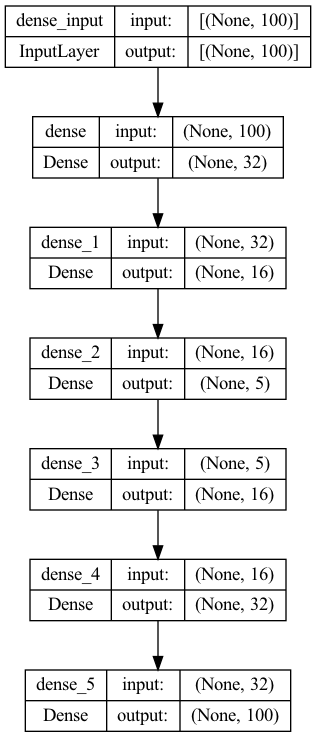

In [25]:
plot_model(model, to_file="../_output/keras_autoencoder_32_16_5.png", show_shapes=True, show_layer_names=True)

Let's evaluate whether or not we should keep training our network by looking at
the plot of train loss compared to the validation loss:


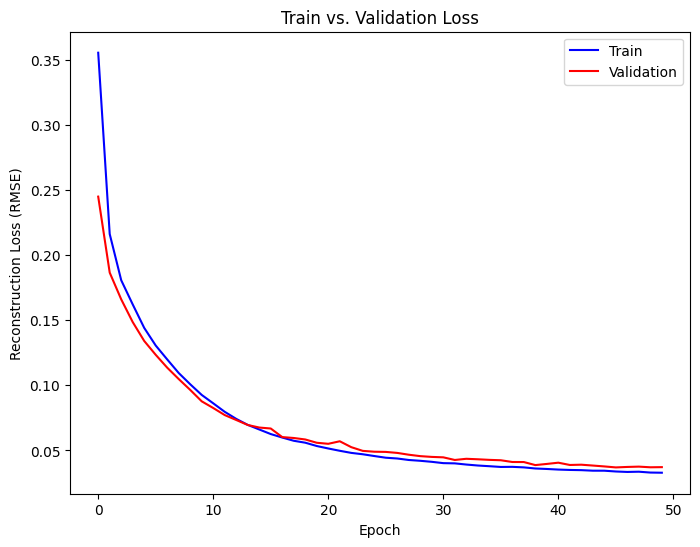

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(history.history["mean_squared_error"], label="Train", c="b")
plt.plot(history.history["val_mean_squared_error"], label="Validation", c="r")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (RMSE)")
plt.title("Train vs. Validation Loss")
plt.legend()
plt.show()


It appears that the train and validation loss are still decreasing, but only
marginally compared to the first few epochs. We could keep training our network,
but there might not be much gain in model performance. So for this example, lets
stop training here and see how reconstructed signals look.


In [27]:
X_train_reconstructed = model.predict(X_train.astype(np.float32))


16/16 [==============================] - 0s 10ms/step


Let's again separate the regular and anomaly signals and see how our autoencoder
fairs in recostructing the signals:


/var/folders/b6/6fn4wmgj471c2xr9pcp8sbdr0000gn/T/ipykernel_76108/3768774765.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, i + 1)


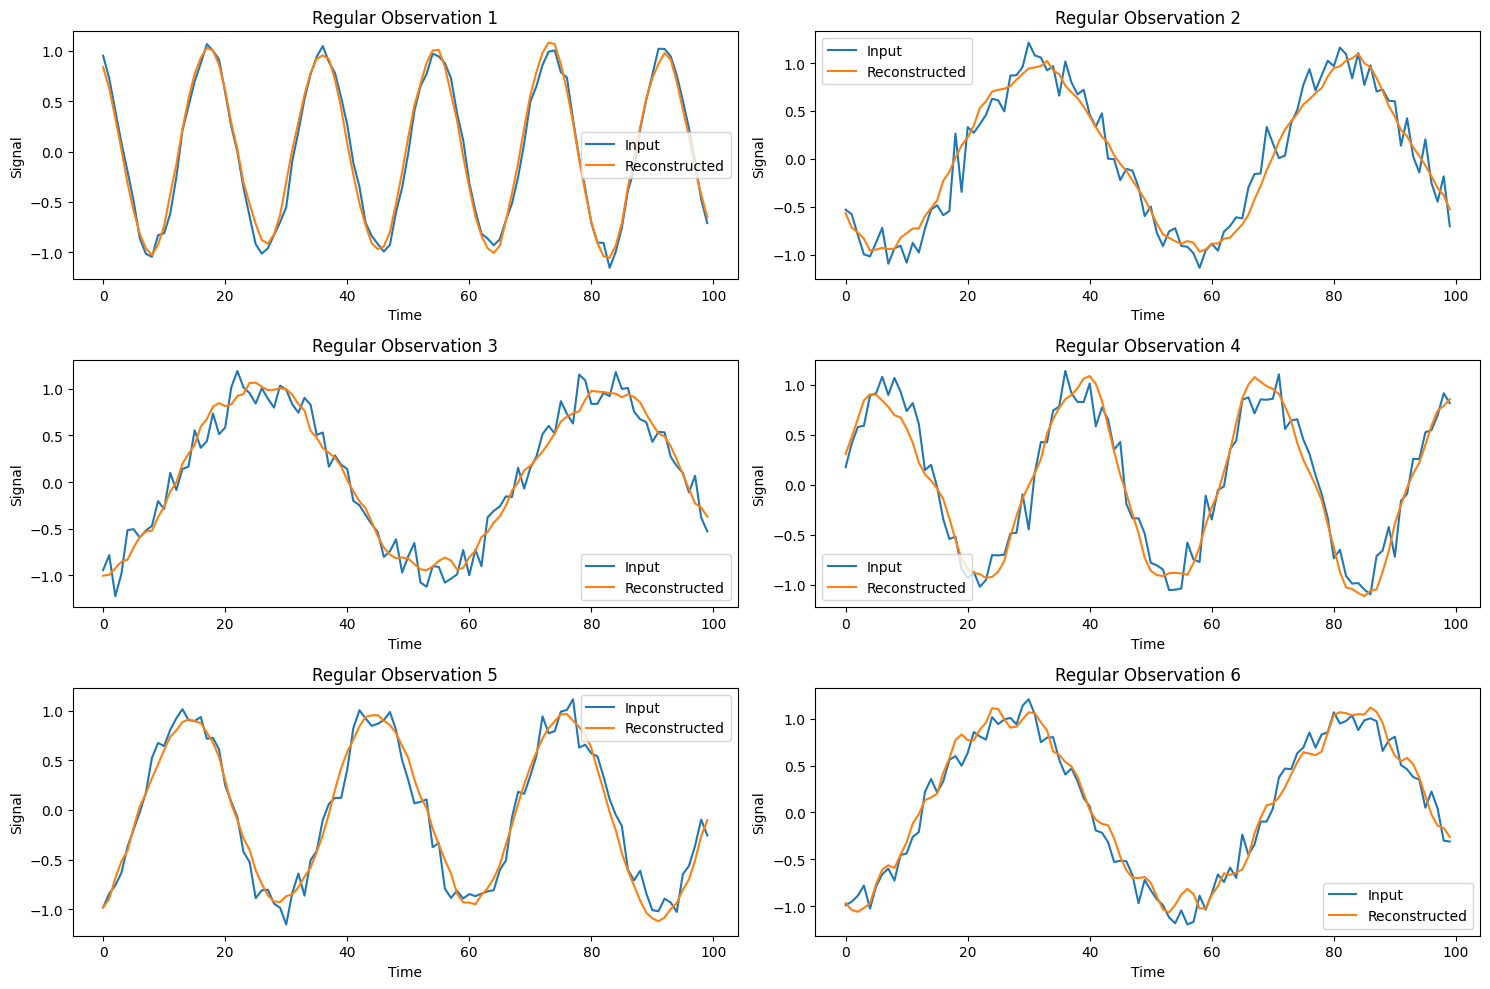

In [28]:
fig = plt.subplots(figsize=(15, 10))

for i in range(6):
    plt.subplot(3, 2, i + 1)
    # filter for regular signals
    plt.plot(X_train[y_train == 0].values[i], label="Input")
    plt.plot(X_train_reconstructed[y_train == 0][i], label="Reconstructed")
    plt.ylabel("Signal")
    plt.xlabel("Time")
    plt.title(f"Regular Observation {i+1}")
    plt.legend()

plt.tight_layout()


As expected, the model output is a smooth version of the original noisy wave
function. Next, we plot the anomaly signals and their reconstruction:


/var/folders/b6/6fn4wmgj471c2xr9pcp8sbdr0000gn/T/ipykernel_76108/2097576278.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, i + 1)


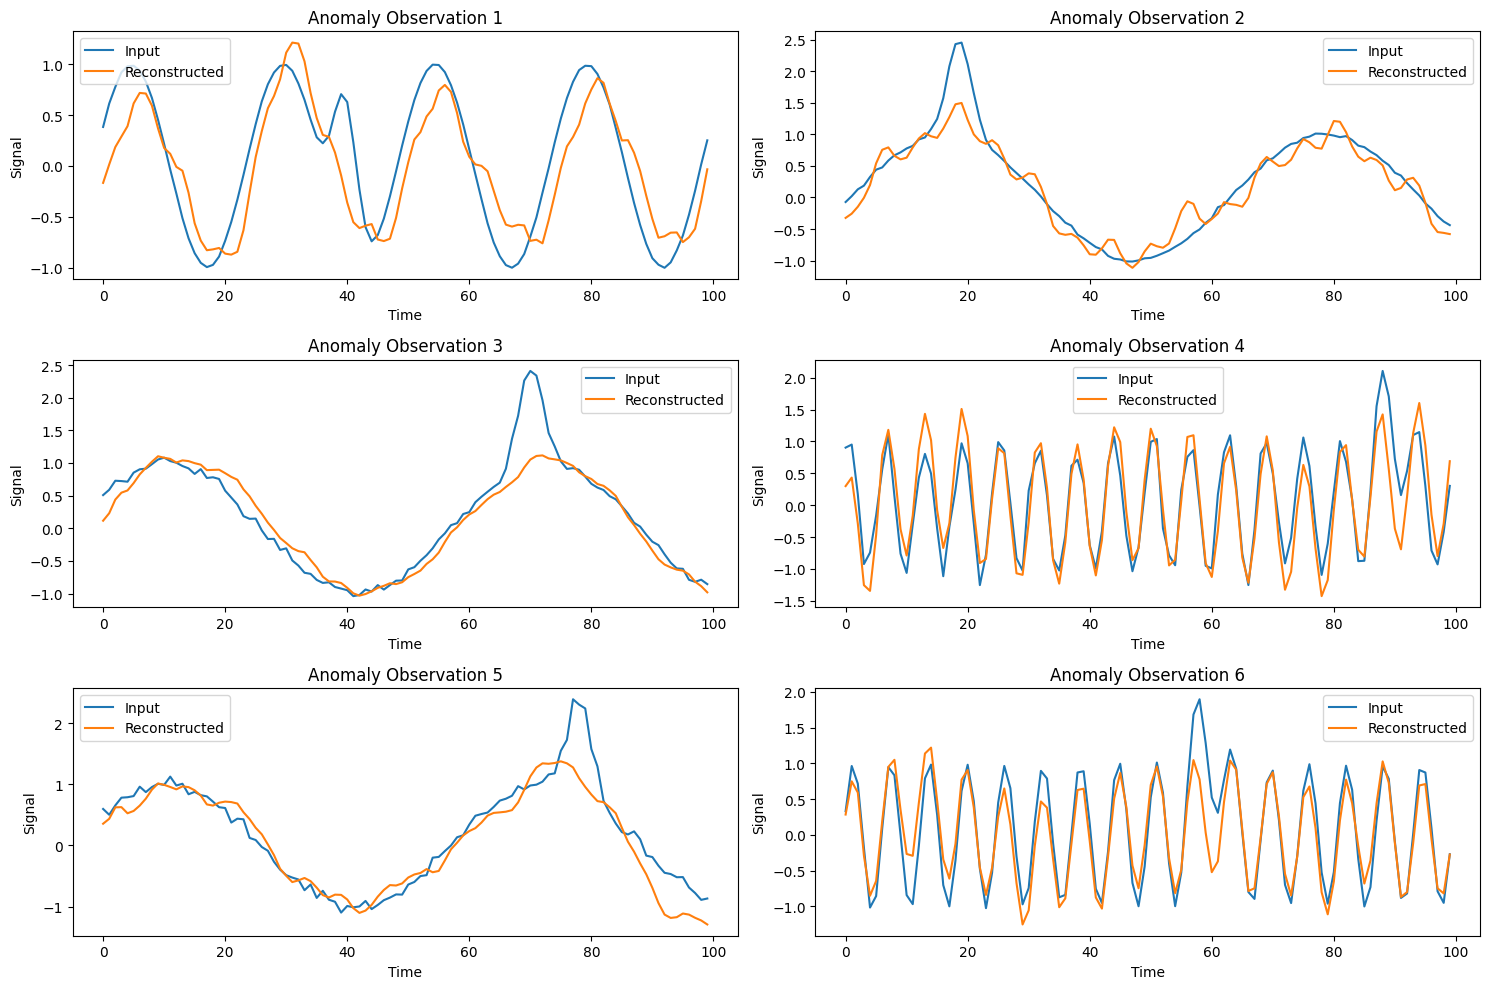

In [29]:
fig = plt.subplots(figsize=(15, 10))

for i in range(6):
    plt.subplot(3, 2, i + 1)
    # filter for anomaly signals
    plt.plot(X_train[y_train == 1].values[i], label="Input")
    plt.plot(X_train_reconstructed[y_train == 1][i], label="Reconstructed")
    plt.ylabel("Signal")
    plt.xlabel("Time")
    plt.title(f"Anomaly Observation {i+1}")
    plt.legend()

plt.tight_layout()


Looking at the plots, it would make sense to calculate the maximum error over
the reconstructed signal since the anomaly is such a localized deviation from
the wave. Note that there are many other applications where the mean
reconstruction error would be a better indicator.


In [30]:
reconstruction_error = (X_train - X_train_reconstructed).abs().max(axis=1)


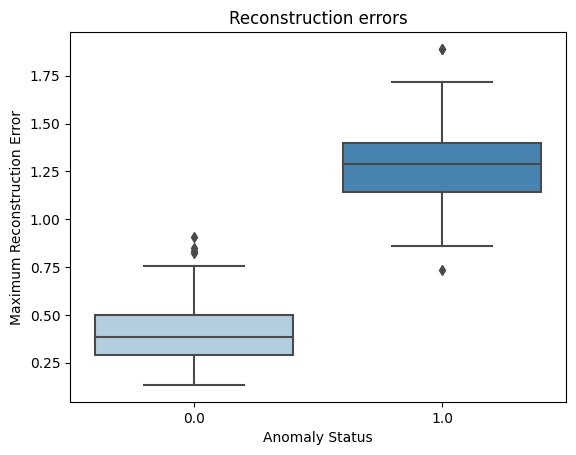

In [31]:
plt.figure()
sns.boxplot(y=reconstruction_error, x=y_train, palette="Blues")
plt.title("Reconstruction errors")
plt.xlabel("Anomaly Status")
plt.ylabel("Maximum Reconstruction Error")
plt.show()


Apart from a few outliers, it seems clear that we can tell anomaly signals apart
from normal signals based on a simple threshold and this reconstruction error.
To account for these ouliers, we will take the 10th percentile of the anomaly
reconstruction errors and classify a signal as anomaly if its reconstruction
error is at least this much.


In [32]:
# learn the threshold from the training set
threshold = np.percentile(reconstruction_error[y_train == 1], 10)

print(threshold)


1.0231541956832941


Note that the threshold was set using the training set. Finally, we can apply
this threshold prediction to the validation set: we calculate the maximal
reconstruction errors over the validation signals and predict a sample to be an
anomaly, if the error is at least the threshold.


In [33]:
# apply model to X_val
X_val_reconstructed = model.predict(X_val.astype(np.float32))

# calculated the reconstruction error for the validation set
validation_errors = (X_val - X_val_reconstructed).abs().max(axis=1)

# predict anomaly if the error is at least the threshold
threshold_pred = (validation_errors >= threshold).astype(int)


16/16 [==============================] - 0s 10ms/step


Let's look at the corresponding classification report:


In [34]:
print(classification_report(y_val, threshold_pred))


              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       454
         1.0       0.95      0.91      0.93        46

    accuracy                           0.99       500
   macro avg       0.97      0.95      0.96       500
weighted avg       0.99      0.99      0.99       500



We managed to increase both the recall and precision on the anomaly class
significantly while still keeping the overall accuracy high (note that the
actual numbers will vary if the model is retrained). A deeper evaluation of
these approaches can be carried out by analyzing the precision-recall curve
given by different thresholds.


**Remark**: in order to extract the compressed representation for each signal
using the model, we can create an encoder that holds the first three layers of
the full autoencoder:


In [35]:
# create separate encoder from the trained layers
encoder = keras.Sequential(model.layers[:3])


In [36]:
encoded_signal = encoder.predict(X_train.astype(np.float32))

encoded_signal.shape


16/16 [==============================] - 0s 2ms/step


(500, 5)

In [37]:
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                3232      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 5)                 85        
                                                                 
Total params: 3,845
Trainable params: 3,845
Non-trainable params: 0
_________________________________________________________________


These vectors can be used for exploring the data set further or in downstream
tasks as features, in particular, to be used to further improve the anomaly
prediction models.


### Exercise 1

Visualize the anomaly signals that were misclassified by the threshold method
considering false positives and false negatives separately. What can you say
about the original and reconstructed signals here?


In [26]:
## YOUR CODE COMES HERE


### Solutions


Let's create the indicator for the false positive and false negative samples of
the validation set.


In [41]:
# misclassified by the threshold-method

# predicted anomaly but normal
false_pos = (threshold_pred == 1) & (y_val == 0)
print(f"Number of FPs: {false_pos.sum()}")

# predicted normal but anomaly
false_neg = (threshold_pred == 0) & (y_val == 1)
print(f"Number of FNs: {false_neg.sum()}")


Number of FPs: 2
Number of FNs: 4


Looking at the FP signal, we see that the autoencoder struggled to properly
reconstruct the non-anomaly wave with a high amount of noise. This resulted in a
high maximal reconstruction error and a false positive classification.


/var/folders/b6/6fn4wmgj471c2xr9pcp8sbdr0000gn/T/ipykernel_76108/1647248866.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, i + 1)


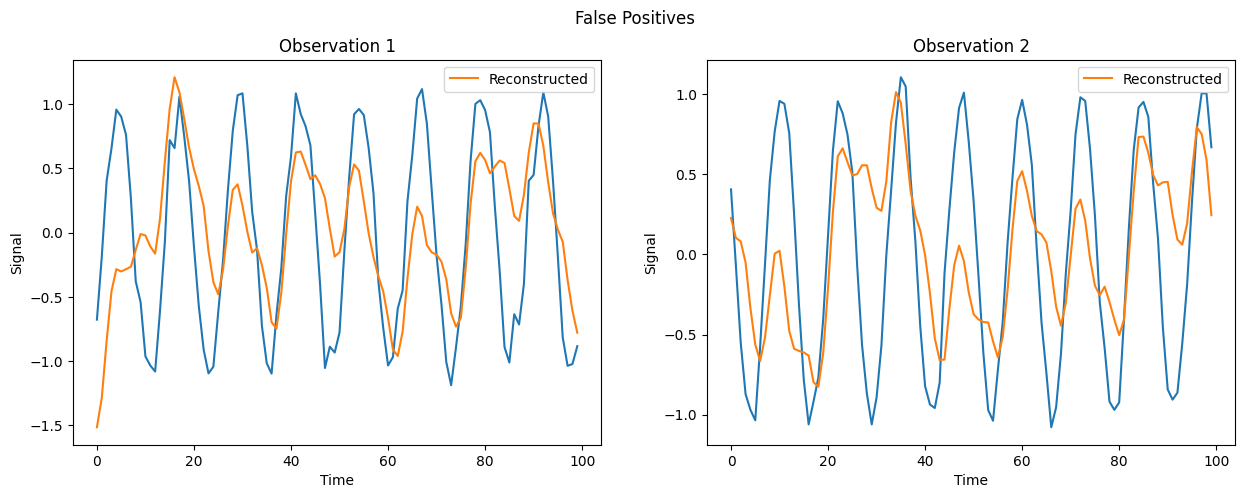

In [39]:
fig = plt.subplots(figsize=(15, 5))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.plot(X_val[false_pos].values[i])
    plt.plot(X_val_reconstructed[false_pos][i], label="Reconstructed")
    plt.ylabel("Signal")
    plt.xlabel("Time")
    plt.title(f"Observation {i+1}")
    plt.legend()

plt.suptitle("False Positives")
plt.legend()
plt.show()


The plot below show some missed anomaly signals that were classified as normal.
The reconstruction is fairly well done but the deviation from the regular signal
is not so substantial.


/var/folders/b6/6fn4wmgj471c2xr9pcp8sbdr0000gn/T/ipykernel_76108/1889702997.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, i + 1)


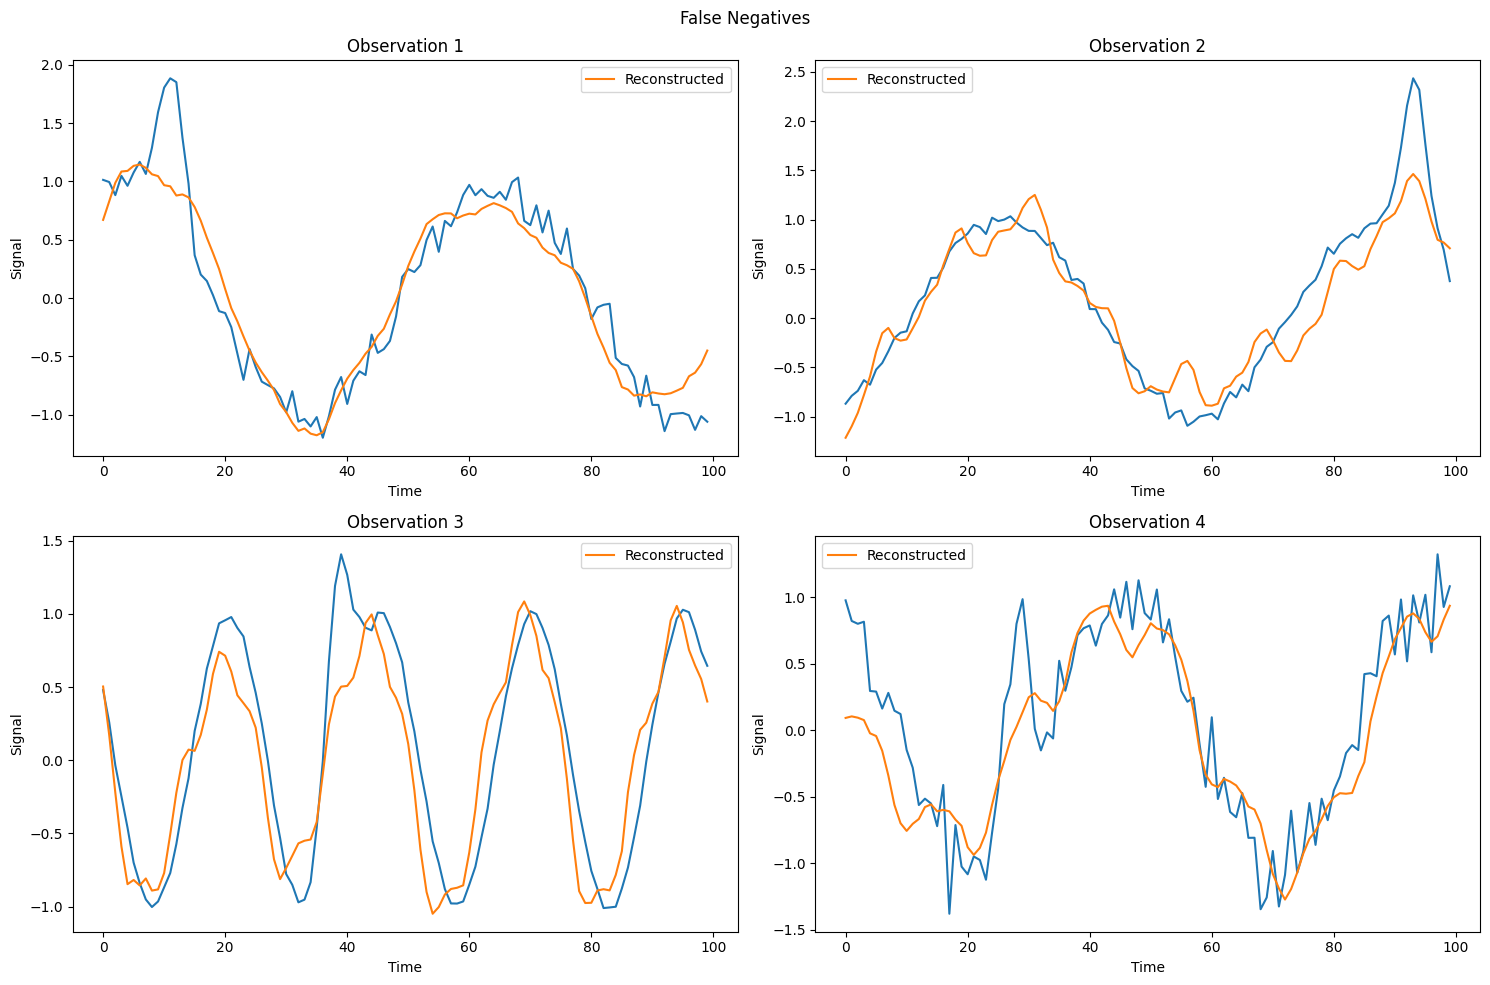

In [40]:
fig = plt.subplots(figsize=(15, 10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(X_val[false_neg].values[i])
    plt.plot(X_val_reconstructed[false_neg][i], label="Reconstructed")
    plt.ylabel("Signal")
    plt.xlabel("Time")
    plt.title(f"Observation {i+1}")
    plt.legend()

plt.suptitle("False Negatives")
plt.tight_layout()
plt.show()


---

## Word Embeddings


_Word embeddings_ are numeric representations of words and text, much like
bag-of-words (BoW) or TF-IDF, most commonly produced by neural networks. One
crucial difference is that the word embeddings produced by neural networks are
relatively low dimensional and dense vectors, 100 to 600 dimensions with most
values non-zero, compared to a typical bag-of-words representation that could
run to the thousands but most values are zero. This makes word embeddings more
computationally tractable.

![word embedding](https://drive.google.com/uc?export=view&id=1v6wCyAVQPKIVCCYPCOg0eRp9pBRQlc-x)

_Word2Vec_ is a specific implementation of word embeddings introduced by
[Tomas Mikolov et al](https://arxiv.org/pdf/1301.3781.pdf) in 2013 that can be
efficiently trained on enormous data sets. Word2Vec is an unsupervised learning
procedure that transforms words into numeric vectors so that semantically
similar words end up mapped to nearby vectors.

The main idea of the Word2Vec training regime is called the _skip-gram model_:
first, we take our documents and split them into windows of consecutive words of
a fixed size. We then take all possible word pairs from these windows which will
be used as input and target for training a neural network with a single hidden
layer (called the embedding layer in this context).

![word2vec](https://drive.google.com/uc?export=view&id=16u-CmiklDAZJdkIYLGVqSaw7V9HFO50t)

The hidden layer of this neural network will provide the word embedding, much
like the middle layer of the autoencoder architecture. This description
oversimplifies a few points but captures the essence of the algorithm. In
particular, the above approach does not scale to large vocabulary sizes (it is
computationally expensive to calculate the softmax over large dimensions) - a
possible way to overcome this is called _negative sampling_. In the latter, we
train a model to distinguish between real pairs of words (coming from proper
windows of the documents) from randomly paired words from the vocabulary. This
reduces the training to a binary classification task (real vs random pair) as
opposed to the multi-class problem of selecting an output word from a large
vocabulary.

![word2vec](https://drive.google.com/uc?export=view&id=1fa5y7CsbUwiNCLqsnEDRC-vJi9_Dqw6Y)


We won't train word embeddings ourselves but load pretrained vectors: we will
use [LexVec](https://github.com/alexandres/lexvec) and Wikipedia. LexVec is a
smarter implementation of Word2Vec that was trained on a full snapshot of the
English version of Wikipedia. Download the file of
[LexVec Wikipedia word vectors from here](https://drive.google.com/file/d/1NtOjkNtbevgg5xWkcop62NYY332tmiJh/view?usp=sharing),
unzip it, and save it to your data directory.

For interacting with the vectors, we will use the `gensim` library.
[`gensim`](https://radimrehurek.com/gensim/intro.html#what-is-gensim) is an
open-source Python library that was developed for working with text
representations and topic modeling in a user-friendly and computationally
efficient way. Other popular general NLP packages include `nltk` and
[`Spacy`](https://spacy.io/), the latter also supporting word embeddings and
other natural language tasks.


In [43]:
import gensim


We can then load up a gensim model with these Wikipedia word vectors (this will
take a few minutes):


In [44]:
model = gensim.models.KeyedVectors.load_word2vec_format("../_data/lexvec.enwiki+newscrawl.300d.W.pos.vectors", binary=False)


In [45]:
dir(model)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_load_specials',
 '_log_evaluate_word_analogies',
 '_save_specials',
 '_smart_save',
 '_upconvert_old_d2vkv',
 '_upconvert_old_vocab',
 'add_lifecycle_event',
 'add_vector',
 'add_vectors',
 'allocate_vecattrs',
 'closer_than',
 'cosine_similarities',
 'distance',
 'distances',
 'doesnt_match',
 'evaluate_word_analogies',
 'evaluate_word_pairs',
 'expandos',
 'fill_norms',
 'get_index',
 'get_mean_vector',
 'get_normed_vectors',
 'get_vecattr',
 'get_vector',
 'has_index_for',
 'index2entity',
 'index2word',
 'index_to_key',
 'init_sims',
 

The individual word embeddings can be accessed just as if the model object was a
dictionary with the keys being the word strings and the values the vectors.


In [47]:
turtle_vector = model["turtle"]
turtle_vector.shape


(300,)

Since each word vector has 300 coordinates, the best way we can visualize them
is as a heat map where brighter stripes indicate higher values in that
particular vector coordinate:


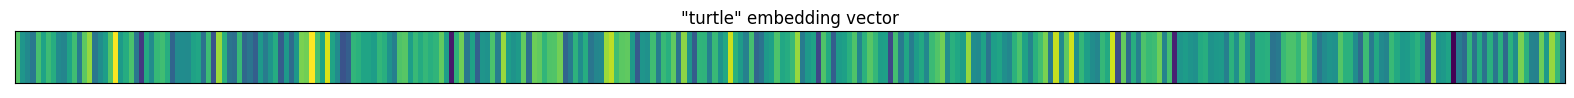

In [48]:
plt.figure(figsize=(20, 5))
plt.imshow(np.tile(model["turtle"], (10, 1)))
plt.xticks([])
plt.yticks([])
plt.title('"turtle" embedding vector')
plt.show()


All the word vectors in the model are stored in a single numpy array in the
`vectors` attribute of the model object.


In [49]:
model.vectors.shape


(368999, 300)

From this, we see that our model stores embeddings to almost 370,000 unique
words.


### Word Similarity


One major application of word embeddings is that they allow to measure the
similarity between individual words. The next plot shows the embeddings for
three words, two of which we know are quite similar in meaning.


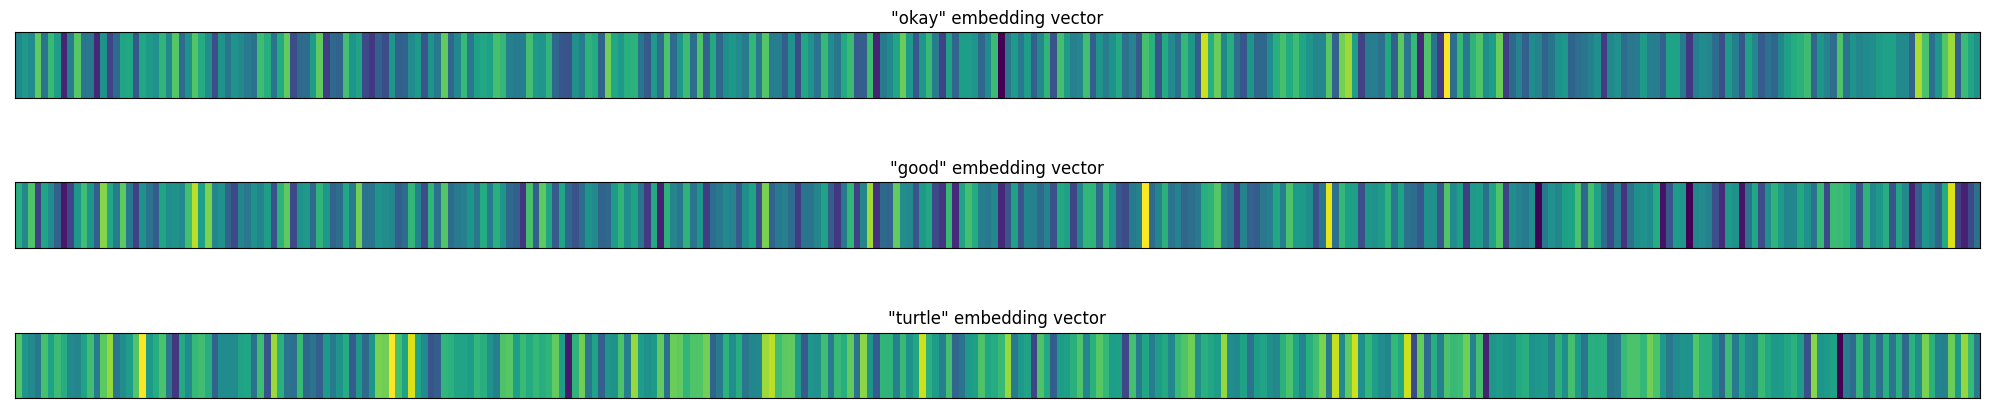

In [50]:
word_list = ["okay", "good", "turtle"]

plt.subplots(len(word_list), 1, figsize=(20, 5))

for i, word in enumerate(word_list):
    plt.subplot(len(word_list), 1, i + 1)
    plt.imshow(np.tile(model[word], (10, 1)))
    plt.xticks([])
    plt.yticks([])
    plt.title(f'"{word}" embedding vector')

plt.tight_layout()
plt.show()


At this point, we can already see that the embeddings for the words 'okay' and
'good' are more similar than either of them to the word 'turtle'. We can
quantify this difference using the cosine similarity:


In [51]:
from scipy.spatial.distance import cosine as cosine_distance

cosine_distance(model["okay"], model["good"])


0.4771358370780945

In [53]:
cosine_distance(model["okay"], model["ok"])

0.10373055934906006

Recall that cosine distance falls between 0 and 1 with higher distances
corresponding to more dissimilar words. The same calculation can be achieved by
calling the built-in `distance` method of the model:


In [54]:
model.distance("okay", "good")


0.4771358370780945

In [55]:
model.distance("okay", "awful")


0.597682923078537

In [56]:
model.distance("okay", "turtle")


0.9985833225073293

Almost any word you can think of is stored in the model's vocabulary. Using the
`most_similar` method of the model, we can find words which are located close by
in our embedding space to any word of our choosing (this again uses cosine
distance).


In [57]:
similar = model.most_similar(positive=["hbo", "fantasy"])

pd.DataFrame(similar, columns=["HBO + Fantasy", "Similarity"])


,HBO + Fantasy,Similarity
0,thrones,0.572184
1,showtime,0.564967
2,horror,0.552821
3,fiction,0.548519
4,drama,0.546923
5,syfy,0.532178
6,thriller,0.522768
7,comedy,0.522304
8,episode,0.516057
9,prequel,0.512276


The top hit is `thrones`, most likely in reference to the HBO fantasy series
Game of Thrones. It has done more than embed similar words close together, it
has learned how to embed _concepts_ that its never seen before. This model was
never trained with an `HBO+Fantasy` token, yet it still learned what is similar
to this concept. This is especially impressive if you look at the most similar
words to `HBO` and `fantasy` individually:


In [58]:
similar_HBO = model.most_similar(positive=["hbo"])
similar_fantasy = model.most_similar(positive=["fantasy"])

pd.DataFrame(data={"HBO": [word for word, sim in similar_HBO], "Fantasy": [word for word, sim in similar_fantasy]})


,HBO,Fantasy
0,showtime,fiction
1,syfy,adventure
2,netflix,novels
3,cinemax,horror
4,starz,cyberpunk
5,itv,steampunk
6,nbc,novel
7,thrones,anime
8,pbs,roleplaying
9,tv,dystopian


`thrones` is near the bottom of the `HBO` list, but by including `fantasy`,
we've pushed it to the top.


In addition to learning useful concepts like those we've seen, these totally
unsupervised models can learn some biased notions from their training data.
Consider the following example:


In [59]:
similar = model.most_similar(positive=["doctor", "woman"], negative=["man"])

pd.DataFrame(similar, columns=["Doctor + Woman - Man", "Similarity"])


,Doctor + Woman - Man,Similarity
0,nurse,0.580535
1,midwife,0.579234
2,doctors,0.560049
3,physician,0.521473
4,gynecologist,0.506105
5,pharmacist,0.492950
6,patient,0.476973
7,pregnant,0.463430
8,nurses,0.462541
9,obstetrician,0.460194


In [60]:
similar = model.most_similar(positive=["doctor", "woman"])

pd.DataFrame(similar, columns=["Doctor + Woman", "Similarity"])

,Doctor + Woman,Similarity
0,man,0.684469
1,girl,0.606095
2,nurse,0.577610
3,teenager,0.541708
4,she,0.541219
5,mother,0.539230
6,midwife,0.528326
7,person,0.514216
8,victim,0.513246
9,boy,0.512039


We didn't do anything to encourage learning associations like this, it was just
an underlying bias present in the data that our model picked up on. If we were
using this embedding as inputs to other models, then we run the risk of having
the other models making biased decisions.

Is there anything we can do about this? This is actually a relatively new area
of research called ethics of learning, but it's beyond the scope of this course.
You should keep in mind that any model you build can have unintended biases
built into it. These models aren't infallible. They are only as good as the data
they are built on.


### Embedding Entire Documents


Based on a word embedding model, we can construct vectors for complete documents
by splitting the documents into words and aggregating the individual embedding
vectors. The most common way to combine the vectors is to take the average but
one can experiment with (weighted) sums too.

For this, we first need to tokenize and slightly clean the texts which we'll do
by a built-in function from `gensim`:


In [61]:
from gensim.utils import simple_preprocess

review = "This is a great movie."

tokenized = simple_preprocess(review)

print(tokenized)


['this', 'is', 'great', 'movie']


As before, we can get the embedding of each individual word:


In [62]:
model["this"].shape


(300,)

These vectors can be stacked into a single numpy array:


In [63]:
word_embeddings = np.stack([model[word] for word in tokenized])
word_embeddings.shape


(4, 300)

Finally, we can take the mean along the sentence to get a single vector
representation:


In [64]:
word_embeddings.mean(axis=0).shape


(300,)

An important point here is that our word embedding model has a fixed vocabulary:
it only has embeddings for words it had seen during training.


In [65]:
"dog" in model


True

In [66]:
"xyzxzy" in model


False

In [70]:
"adeyinka" in model

False

With this in mind, we are ready to wrap this whole process into a small function
that can embed any sentence by skipping words not in the model.


In [71]:
def sentence2vec(text):
    """
    Embed a sentence by averaging the word vectors of the tokenized text. Out-of-vocabulary words are replaced by the zero-vector.
    -----

    Input: text (string)
    Output: embedding vector (np.array)
    """
    tokenized = simple_preprocess(text)

    word_embeddings = [np.zeros(300)]
    for word in tokenized:
        # if the word is in the model then embed
        if word in model:
            vector = model[word]
        # add zeros for out-of-vocab words
        else:
            vector = np.zeros(300)

        word_embeddings.append(vector)

    # average the word vectors
    sentence_embedding = np.stack(word_embeddings).mean(axis=0)

    return sentence_embedding


We will test this method by looking at two similarly positive reviews and a
negative one. What we expect is that the embeddings of the first two will be
much closer than the good vs bad reviews.


In [72]:
good_emb1 = sentence2vec("This is a great movie.")
good_emb2 = sentence2vec("What an awesome film.")
bad_emb = sentence2vec("I don't recommend seeing it, horrible.")


In [73]:
cosine_distance(good_emb1, good_emb2)


0.24843538359756256

In [74]:
cosine_distance(good_emb1, bad_emb)


0.460715352398836

In [75]:
cosine_distance(good_emb2, bad_emb)


0.4453171862702269

Note that the review texts here have no overlap in vocabulary, so if we were to
calculate the cosine distance based on bag-of-words, we would get the maximal
distance 1 between any two of these reviews.

One obvious shortcoming of this naive `sentence2vec` approach is that it does
not capture word order. Following up on the success of word embeddings,
researchers developed various
[document embedding models](https://arxiv.org/pdf/1405.4053v2.pdf) that can
directly embed full texts and provide better performance than aggregated word
embeddings.

There are many alternative word-embeddings to `Word2vec` depending on how the
embedding training is carried out. A popular approach called
[`GloVe`](https://nlp.stanford.edu/projects/glove/) learns word vectors based on
the probability of word co-occurrence. The problem of out-of-vocabulary words
has also been addressed in various ways: the
[`FastText`](https://radimrehurek.com/gensim/models/fasttext.html) approach
embeds character n-grams which allows the model to represent words that were
originally not present in the training set.


### Word Embeddings as Predictive Features


Apart from word and document similarity, we can use the embeddings as features
for a downstream predictive task. Let's revisit the Rotten Tomatoes dataset
(download form
[here](https://drive.google.com/uc?export=view&id=1rP_ptLK22xZquv8rZx4V48iD6Ht4_OqG))
and see how the document representations would serve in analysing the sentiment
of movie reviews:


In [76]:
reviews = pd.read_csv("../_data/rottentomatoes.csv", index_col=0)

# filter out the neutral reviews
reviews = reviews[reviews.Sentiment != 2]

# binarize the sentiment score
reviews["Sentiment"] = np.where(reviews["Sentiment"] >= 3, 1, 0)


In [77]:
reviews.head()


,Phrase,Sentiment
SentenceId,,
1,A series of escapades demonstrating the adage ...,0
2,"This quiet , introspective and entertaining in...",1
3,"Even fans of Ismail Merchant 's work , I suspe...",0
4,A positively thrilling combination of ethnogra...,1
5,Aggressive self-glorification and a manipulati...,0


In [78]:
reviews["Sentiment"].value_counts(normalize=True)


1    0.524003
0    0.475997
Name: Sentiment, dtype: float64

Our first model, a simple baseline, will use the bag-of-words representation and
a logistic regression classifier:


In [79]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

X_train = reviews["Phrase"]
y_train = reviews["Sentiment"]

logreg = Pipeline(
    [
        ("vectorizer", CountVectorizer(lowercase=True, stop_words="english", min_df=5)),
        ("classifier", LogisticRegression(max_iter=1000)),
    ]
)


In [80]:
grid_search = GridSearchCV(logreg, {"classifier__C": [0.01, 0.1, 1, 10, 100]})

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)


Best parameters:  {'classifier__C': 1}


The best performing model achieved an average 75% accuracy over the 5-fold cross
validation:


In [81]:
grid_search.best_score_


0.7540022760354639

Note that is definitely better than the chance: predicting 0 for all samples
would give 52% accuracy.


Now the word embedding approach: we use our previous `sentence2vec` function to
embed our reviews and then use them as the predictors for logistic regression.
The first step is to apply the function to each review:


In [82]:
X_train_emb = X_train.apply(sentence2vec)

X_train_emb.head()


SentenceId
1    [0.04111585248371258, -0.03950611814883921, 0....
2    [0.05578700165497139, 0.04393529902445152, 0.0...
3    [-0.023141250829212368, 0.016616624081507325, ...
4    [0.008443476055704412, 0.02024776116013527, 0....
5    [0.013268856664321252, -0.009236856762851988, ...
Name: Phrase, dtype: object

The resulting object is a `pandas.Series` holding the 300-dimensional embeddings
which we now transform into a numpy array:


In [83]:
X_train_emb = np.array(X_train_emb.tolist())


In [84]:
X_train_emb.shape


(6874, 300)

### Exercise 2

Train a classifier of your choice on the embedded sentences (it could be a
logistic regression, random forest or even a neural network). How does this
model compare to the baseline model fitted on the countvectorized input?


In [72]:
## YOUR CODE COMES HERE


### Solution - logistic regression


In [85]:
logreg = LogisticRegression(max_iter=1000)

grid_search = GridSearchCV(logreg, {"C": [0.01, 0.1, 1, 10, 100]})

grid_search.fit(X_train_emb, y_train)

print("Best parameters: ", grid_search.best_params_)


Best parameters:  {'C': 10}


The best mean CV-score is definitely higher and the calculation ran in half the
time:


In [86]:
grid_search.best_score_


0.7924052401746725

### Solution - neural network


In [87]:
# random seeds for reproducability
np.random.seed(123)
tf_random.set_seed(123)

# create a new sequential model
model = keras.Sequential()

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation="softmax"))  # output layer

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=keras.metrics.SparseCategoricalAccuracy(),
)


# train our model
history = model.fit(X_train_emb.astype(np.float32), y_train, validation_split=0.2, epochs=10, verbose=1)


Epoch 1/10


/Users/nishant/src/work/brainstation/datascience-bootcamp/.venv/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


172/172 [==============================] - 2s 6ms/step - loss: 0.5745 - sparse_categorical_accuracy: 0.6912 - val_loss: 0.4735 - val_sparse_categorical_accuracy: 0.7716
Epoch 2/10
172/172 [==============================] - 1s 4ms/step - loss: 0.4563 - sparse_categorical_accuracy: 0.7836 - val_loss: 0.4558 - val_sparse_categorical_accuracy: 0.7789
Epoch 3/10
172/172 [==============================] - 1s 4ms/step - loss: 0.4310 - sparse_categorical_accuracy: 0.7972 - val_loss: 0.4572 - val_sparse_categorical_accuracy: 0.7833
Epoch 4/10
172/172 [==============================] - 1s 4ms/step - loss: 0.4186 - sparse_categorical_accuracy: 0.8049 - val_loss: 0.4454 - val_sparse_categorical_accuracy: 0.7935
Epoch 5/10
172/172 [==============================] - 1s 4ms/step - loss: 0.4092 - sparse_categorical_accuracy: 0.8101 - val_loss: 0.4449 - val_sparse_categorical_accuracy: 0.7978
Epoch 6/10
172/172 [==============================] - 1s 4ms/step - loss: 0.3918 - sparse_categorical_accuracy:

We can achieve ~80% accuracy with the neural network.


---

### Conclusions


Autoencoders can be applied to learn universal representations of various data
types from tabular to image and audio data, one just needs to adapt the layers
of the network (e.g., replace fully connected with convolutional layers if
processing images).

The learned representations can be used in various settings:

- as features for downstream modeling tasks such as a classification,
- in information retrieval systems, the compressed representation can provide a
  fast way to look up similar items in large databases (see
  [semantic hashing](https://www.cs.utoronto.ca/~rsalakhu/papers/semantic_final.pdf)),
  or
- one can use the full trained encoder module as part of a new predictive model
  (in the spirit of transfer learning).

There are types of autoencoders that can be used as generative models to produce
synthetic images (see
[variational autoencoders](https://en.wikipedia.org/wiki/Variational_autoencoder)),
and so-called
[denoising autoencoders](https://en.wikipedia.org/wiki/Autoencoder#Variations)
which are specifically trained to reconstruct corrupted inputs. You can find
more theoretical background in
[Chapter 14 of Deep Learning](https://www.deeplearningbook.org/) by Goodfellow
et at. and further applications in
[Chapter 17 of Hands-on Machine Learning with Keras](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)
by Geron.


In recent years, there has been huge breakthroughs in natural language modeling
and bringing the ideas of transfer learning from computer vision to NLP. The
resulting universal text representations can be used to solve various downstream
tasks from predictive modeling to recommendation systems. New advances also
include the development of novel neural network architectures, such as the
[transformers](https://jalammar.github.io/illustrated-transformer/), and the use
of increasingly large training sets. The resulting large language models such as
[BERT](https://arxiv.org/abs/1810.04805) and the
[GPT](https://openai.com/blog/better-language-models/) model family are now
widely applied to address various industry applications.

The field is currently looking how to make the models smaller while not
compromising on accuracy, serving low-resource languages and addressing the
issue of biases discussed earlier.
